# Neural Network

## Enviroment

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math

import sys
sys.path.append('../')

from Preprocessing import preprocessing
from Preprocessing.single_set import SingleSet

In [19]:
%matplotlib inline

## Data Preprocessing

Features: data.data_features
Targets: data.data_targets (click, bidprice, payprice)

In [4]:
train_data_path = '/Data/train.csv'
train_data = SingleSet(relative_path=train_data_path,use_numerical_labels=True)

val_data_path = '/Data/validation.csv'
val_data = SingleSet(relative_path=val_data_path,use_numerical_labels=True)

test_data_path = '/Data/test.csv'
test_data = SingleSet(relative_path=test_data_path,use_numerical_labels=True)

-- data loaded --
-- data loaded --


In [81]:
def pandas_to_numpy(data):

    ## features
    features = np.asarray(data.data_features.values)

    ## targets
    if hasattr(data, "data_targets"):
        labels = np.asarray(data.data_targets.values)
        
    return features, labels



## drop unnecessary features
def drop_features(data):
    
    if 'userid' in data.data_features:
        data.data_features.drop('userid', axis=1, inplace = True)
        
    if 'urlid' in data.data_features:
        data.data_features.drop('urlid', axis=1, inplace = True)


drop_features(train_data)
drop_features(val_data)

x_train, y_train = pandas_to_numpy(train_data)
x_val, y_val = pandas_to_numpy(val_data)
x_test = pandas_to_numpy(val_data)

### Data Input Shapes

In [9]:
input_shape = x_train.shape[1]
output_shape = 1

# targets_________________________________________________

# clicks
y_train_clicks = np.reshape(y_train[:,0], (y_train.shape[0], 1))  # get first column (clicks)
y_val_clicks = np.reshape(y_val[:,0], (y_val.shape[0], 1))  # get first column (clicks)

# payprice
y_train_payprice = np.reshape(y_train[:,2], (y_train.shape[0], 1))  # get third column (payprice)
y_val_payprice = np.reshape(y_val[:,2], (y_val.shape[0], 1))  # get third column (payprice)

### Scale Data

In [10]:
# normalize the data attributes
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#normalized_X = preprocessing.normalize(x_train)



## features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(np.concatenate((x_train, x_val, x_test), axis = 0))       

x_train = feature_scaler.transform(x_train)
x_val = feature_scaler.transform(x_val)
x_test = feature_scaler.transform(x_test)

## Targets________________________________________

# payprice
payprice_scaler = MinMaxScaler(feature_range=(0, 1))
payprice_scaler.fit(np.concatenate((y_train_payprice, y_val_payprice), axis = 0))   

y_train_payprice = payprice_scaler.transform(y_train_payprice)
y_val_payprice = payprice_scaler.transform(y_val_payprice)



## Model - Neural Networks

Train Baseline Accuracy "Clicks": 0.9992618932746251%
#of 0:    2429188     # of 1:       1793


Val Baseline Accuracy "Clicks": 0.9993349203056733%
#of 0:    303723     # of 1:       202

### "Click" - Binary Classification

In [38]:
#from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model, Input
from keras import optimizers

from random import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings
warnings.filterwarnings('ignore', '.*do not.*',)



def create_model_clicks(input_shape, output_shape):

    ## sequential model
    model = Sequential()
    
    model.add(Dense(24, input_dim=input_shape, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    # working model___________
    #model.add(Dense(3, input_dim=input_shape, activation='relu'))
    #model.add(Dense(12, activation='relu'))
    #model.add(Dense(12, activation='relu'))


    #model.add(Dropout(0.5))
    #model.add(Dropout(0.1))
    model.add(Dense(output_shape, activation='sigmoid'))

    ## other way of defining model
    
    #inputs = Input(shape=(input_shape,))
    #outputs = Dense(output_shape, activation="relu", kernel_regularizer=regularizers.l2(5e-4),kernel_initializer=initializers.he_normal(seed=13))(inputs)
    #model = Model(inputs=inputs, outputs=outputs, name='bidder')

    return model


def plot_curves(history):

    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'],'cadetblue', linewidth=3.0)
    plt.plot(history.history['val_loss'],'midnightblue', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=12)
    plt.xlabel('Epochs ', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Loss Curves', fontsize=16, fontweight="bold")
    #plt.savefig('Results/neural_network/loss_curve.png')
    #plt.show()

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['acc'],'cadetblue', linewidth=3.0)
    plt.plot(history.history['val_acc'], 'midnightblue', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
    plt.xlabel('Epochs ', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy Curves', fontsize=16, fontweight="bold")
    #plt.savefig('Results/neural_network/accuracy_curve.png')
    plt.show()


## Upsampling

sample up "1"s for more balanced classification

--> default accuracy: 50%

In [39]:
def upsampling(x, y):

    xy = np.concatenate((x, y), axis = 1)

    zeros = xy[xy[:,-1] == 0]
    ones = xy[xy[:,-1] == 1]

    ones_upsampled = np.repeat(ones, math.ceil(len(zeros)/len(ones)), axis=0)

    # cut at length of zeros.shape 2429188
    ones_upsampled = ones_upsampled[:zeros.shape[0]]

    xy_upsampled  = np.concatenate((ones_upsampled, zeros), axis = 0) # combine
    np.random.shuffle(xy_upsampled)                                   # shuffle

    x_upsampled = xy_upsampled[:,:-1]   # features
    y_upsampled = xy_upsampled[:,-1:]   # targets
    
    return x_upsampled, y_upsampled


x_train_up, y_train_clicks_up = upsampling(x_train, y_train_clicks)

### Integer / Categorical One-Hot Encoding

In [40]:
#y_train_clicks_up = keras.utils.to_categorical(y_train_clicks_up, 2)
#y_val_clicks = keras.utils.to_categorical(y_val_clicks, 2)

y_train_clicks_up = y_train_clicks_up.astype(int)
y_val_clicks = y_val_clicks.astype(int)

### Binary Model Compile

Click Classifier - features:  20 targets:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 24)                504       
_________________________________________________________________
dense_91 (Dense)             (None, 12)                300       
_________________________________________________________________
dropout_39 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 6)                 78        
_________________________________________________________________
dropout_40 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 7         
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________

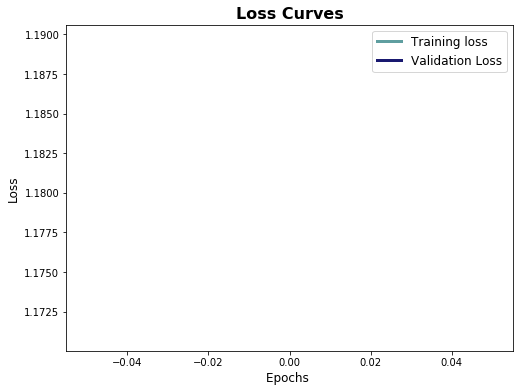

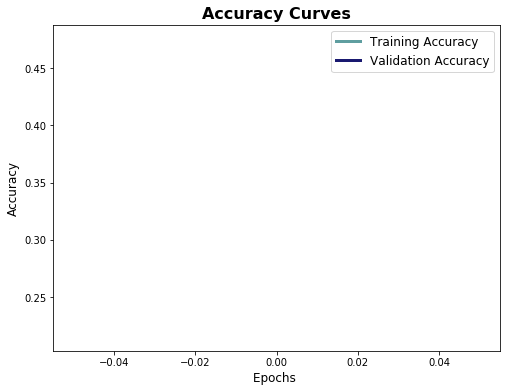

saved model to disk


In [58]:
print("Click Classifier - features: ", input_shape, "targets: ", output_shape)

# Clear model, and create it
model_clicks = create_model_clicks(input_shape, output_shape)
print(model_clicks.summary())
    

## hyperparameters_______________________________________
    

## model compile and train
model_clicks.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# specify learning rate
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint('Results/neural_network/' + 'trained_weights.h5', monitor='loss', save_best_only=True)]

# Fit the model on the batches
batch_size = 1000024
epochs = 1
history = model_clicks.fit(x=x_train_up, y=y_train_clicks_up, batch_size=batch_size, 
                    epochs=epochs, validation_data=(x_val_scaled, y_val_clicks))
# verbose=1, shuffle=True, callbacks=callbacks

## model evaluate
plot_curves(history)


## save model to disk_____________________________________

# serialize model to JSON
model_json = model_clicks.to_json()

if not os.path.exists('Results/neural_network'):
    os.makedirs('Results/neural_network/')

with open('Results/neural_network/click_architecture.json', "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model_clicks.save_weights('Results/neural_network/click_weights.h5')
print("saved model to disk")



### Prediction

In [15]:
## Load Model for Testing_______________________________________________________________

# Model reconstruction from JSON file
#with open('Results/neural_network/' + 'model_architecture.json', 'r') as f:
#    model_test = model_from_json(f.read())

# Load weights into the new model
#model_test.load_weights('Results/neural_network/' + 'trained_weights.h5')

#model_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


click_predictions = model_clicks.predict_classes(x_val, verbose=1)
click_predictions_df = pd.DataFrame(click_predictions, columns= ['click'])

print(click_predictions_df['click'].value_counts())

from sklearn import metrics
print("\nF1_score:", metrics.f1_score(y_val_clicks, click_predictions, average='weighted'))
print("Accuracy:", metrics.accuracy_score(y_val_clicks, click_predictions))


#test_score = model.evaluate(x = x_val, y = y_val)
#print('\ntest accuracy:', test_score[1])

303925/303925 [==============================] - 2s 7us/step
0    260080
1     43845
Name: click, dtype: int64

F1_score: 0.9214984415339882
Accuracy: 0.8555071152422473


### "Payprice" - Float Model

In [21]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model, Input
from keras import optimizers

import matplotlib.pylab as plt
from random import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings
warnings.filterwarnings('ignore', '.*do not.*',)



def create_model_payprice(input_shape, output_shape):

    ## sequential model
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, activation='relu'))
    model.add(Dense(20, input_dim=input_shape, activation='relu'))
    model.add(Dense(12, input_dim=input_shape, activation='relu'))
    model.add(Dense(4, activation='linear'))

    # working model___________
    #model.add(Dense(3, input_dim=input_shape, activation='relu'))
    #model.add(Dense(12, activation='relu'))
    #model.add(Dense(12, activation='relu'))


    #model.add(Dropout(0.5))
    #model.add(Dropout(0.1))
    model.add(Dense(output_shape))

    ## other way of defining model
    
    #inputs = Input(shape=(input_shape,))
    #outputs = Dense(output_shape, activation="relu", kernel_regularizer=regularizers.l2(5e-4),kernel_initializer=initializers.he_normal(seed=13))(inputs)
    #model = Model(inputs=inputs, outputs=outputs, name='bidder')

    return model

    
def plot_curves(history):

    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'],'cadetblue', linewidth=3.0)
    plt.plot(history.history['val_loss'],'midnightblue', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=12)
    plt.xlabel('Epochs ', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Loss Curves', fontsize=16, fontweight="bold")
    #plt.savefig('Results/neural_network/loss_curve.png')
    #plt.show()

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['acc'],'cadetblue', linewidth=3.0)
    plt.plot(history.history['val_acc'], 'midnightblue', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
    plt.xlabel('Epochs ', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy Curves', fontsize=16, fontweight="bold")
    #plt.savefig('Results/neural_network/accuracy_curve.png')
    plt.show()





### Compile Model "Payprice"

features:  20 targets:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_100 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_101 (Dense)            (None, 12)                252       
_________________________________________________________________
dense_102 (Dense)            (None, 4)                 52        
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 5         
Total params: 1,149
Trainable params: 1,149
Non-trainable params: 0
_________________________________________________________________
None
Train on 2430981 samples, validate on 303925 samples
Epoch 1/1
2430981/2430981 [=============================

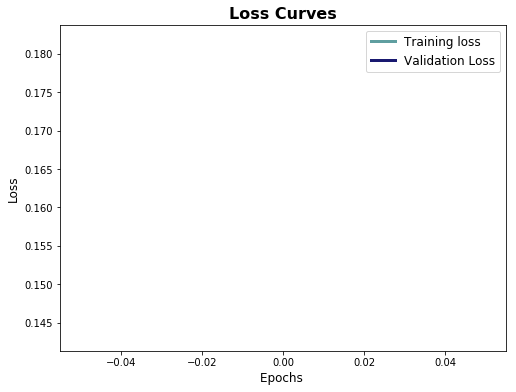

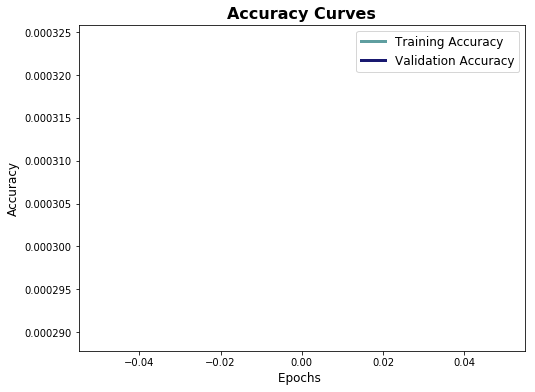

saved model to disk


In [60]:
print("features: ", input_shape, "targets: ", output_shape)

# Clear model, and create it
model_payprice = create_model_payprice(input_shape, output_shape)
print(model_payprice.summary())


## hyperparameters_______________________________________
    

## model compile and train
model_payprice.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# specify learning rate
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint('Results/neural_network/' + 'trained_weights.h5', monitor='loss', save_best_only=True)]

# Fit the model on the batches
batch_size = 10000028
epochs = 1
history = model_payprice.fit(x=x_train, y=y_train_payprice, batch_size=batch_size, 
                    epochs=epochs, validation_data=(x_val, y_val_payprice))
# verbose=1, shuffle=True, callbacks=callbacks

## model evaluate
plot_curves(history)


## save model to disk_____________________________________

# serialize model to JSON
model_json = model_payprice.to_json()

if not os.path.exists('Results/neural_network'):
    os.makedirs('Results/neural_network/')

with open('Results/neural_network/payprice_architecture.json', "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model_payprice.save_weights('Results/neural_network/payprice_weights.h5')
print("saved model to disk")

### Prediction

In [23]:
## Load Model for Testing_______________________________________________________________

# Model reconstruction from JSON file
#with open('Results/neural_network/' + 'model_architecture.json', 'r') as f:
#    model_test = model_from_json(f.read())

# Load weights into the new model
#model_test.load_weights('Results/neural_network/' + 'trained_weights.h5')

#model_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

payprice_predictions_scaled = model_payprice.predict(x_val, verbose=1)

# scale back
payprice_predictions = payprice_scaler.inverse_transform(payprice_predictions_scaled)
payprice_predictions_df = pd.DataFrame(payprice_predictions, columns= ['payprice'])

from sklearn import metrics
print("\nMean Squared Error:", metrics.mean_squared_error(payprice_scaler.inverse_transform(y_val_payprice), payprice_predictions))
print("\n", payprice_predictions_df)

#test_score = model.evaluate(x = x_val, y = y_val)
#print('\ntest accuracy:', test_score[1])

303925/303925 [==============================] - 2s 8us/step

Mean Squared Error: 3313.1624832475604

           payprice
0        31.083591
1        94.842720
2        65.033401
3        67.184372
4        51.259716
5        30.682362
6        49.363663
7        36.500805
8        65.452599
9        61.337212
10       65.718590
11       44.020817
12       62.902653
13       69.880318
14      122.598511
15       55.613022
16       56.569275
17      110.564392
18       57.079155
19       66.566528
20       43.909782
21       56.933334
22       47.697189
23       66.917572
24       20.663416
25       43.528099
26       70.757042
27       64.981941
28       73.918495
29       88.502625
...            ...
303895  126.395195
303896   31.557482
303897   26.427261
303898   79.310196
303899   60.414410
303900   16.100155
303901   57.160057
303902   63.523998
303903   68.823380
303904   86.872795
303905   36.488918
303906   81.461594
303907   78.720184
303908   85.652473
303909   49.246601
3039

# Make Bidding

## Predict Clicks and Payprice

In [70]:
train_data_path = '/Data/train.csv'
train_data = SingleSet(relative_path=train_data_path,use_numerical_labels=True)

val_data_path = '/Data/validation.csv'
val_data = SingleSet(relative_path=val_data_path,use_numerical_labels=True)

test_data_path = '/Data/test.csv'
test_data = SingleSet(relative_path=test_data_path,use_numerical_labels=True)

-- data loaded --
-- data loaded --
saved pickle
-- data loaded --


In [79]:
def pandas_to_numpy(data):

    ## features
    features = np.asarray(data.data_features.values)

    ## targets
    if hasattr(data, "data_targets"):
        labels = np.asarray(data.data_targets.values)
        
    return features, labels



## drop unnecessary features
def drop_features(data):
    
    if 'userid' in data.data_features:
        data.data_features.drop('userid', axis=1, inplace = True)
        
    if 'urlid' in data.data_features:
        data.data_features.drop('urlid', axis=1, inplace = True)


drop_features(train_data)
drop_features(val_data)
drop_features(test_data)

x_train, y_train = pandas_to_numpy(train_data)
x_val, y_val = pandas_to_numpy(val_data)
x_test = drop_features(test_data)

### Scale Data

In [ ]:
# normalize the data attributes
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

## features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(np.concatenate((x_train, x_val, x_test), axis = 0))       

x_train = feature_scaler.transform(x_train)
x_val = feature_scaler.transform(x_val)
x_test = feature_scaler.transform(x_test)

## Load Models

In [82]:
## Load Models for Bidding _______________________________________________________________


## CLICKS___________

# Model reconstruction from JSON file
with open('Results/neural_network/click_architecture.json', 'r') as f:
    model_clicks = model_from_json(f.read())

# Load weights into the new model
model_clicks.load_weights('Results/neural_network/click_weights.h5')


## PAYPRICE___________

# Model reconstruction from JSON file
with open('Results/neural_network/payprice_architecture.json', 'r') as f:
    model_payprice = model_from_json(f.read())

# Load weights into the new model
model_payprice.load_weights('Results/neural_network/payprice_weights.h5')

## Predict

In [149]:
predict_data = x_val

## CLICKS___________

click_predictions = model_clicks.predict_classes(predict_data, verbose=1)

## PAYPRICE___________

payprice_predictions_scaled = model_payprice.predict(predict_data, verbose=1)
payprice_predictions = payprice_scaler.inverse_transform(payprice_predictions_scaled)


303925/303925 [==============================] - 6s 19us/step


## Make Bidding Decision

In [155]:
def set_bids(bids, click_predictions, payprice_predictions):

## 1.) Only bid for expected clicks!

    for p in range(0, len(bids)):

        if click_predictions[p] == 1:
            #bids[p] = payprice_predictions[p]
            bids[p] = 160
            
    return bids



def set_bidprices(bids, budget, payprice_predictions):
    
    ## 2.) Prefer cheap payprice predictions
    
    budget = 6250000
    planned_bid_amount = sum(bids)
    exceed_budget = 0
    n_bids = len(bids[np.where(bids > 0)])

    while (planned_bid_amount > budget + exceed_budget):

        index, = list(np.where(bids == max(bids)))    # find expensive bids
        bids[index] = max(bids) - 1                   # set expensive bid lower
        planned_bid_amount = sum(bids)                # check new bidding amount

    n_bids = len(bids[np.where(bids > 0)])  
    print("planned_bid_amount:", sum(bids), ", difference to budget:", (budget - sum(bids)), 
          ", number of bids:", n_bids, ", average bidprice:",round(np.mean(bids)))
    
    return bids

    

In [158]:
bid_array = np.zeros((len(predict_data)))

bid_decisions = set_bids(bid_array, click_predictions, payprice_predictions)
bids = set_bidprices(bid_decisions, budget, payprice_predictions)


planned_bid_amount: 6214320.0 , difference to budget: 35680.0 , number of bids: 46032 , average bidprice: 20.0


## Test Decision in Auction

In [159]:
data_path = os.path.abspath(os.pardir + '/Data/validation.csv')
df = pd.read_csv(data_path, na_values=['Na', 'null']).fillna(0)

In [161]:
budget = 6250000

## Evaluation Stats_____________

bids_won = 0
earned_clicks = 0
ctr = 0                  # bids_won / earned_clicks
total_paid = 0
cpc = 0                  # cost per click


for index, row in df.iterrows():

    if bids[index] > budget: # check if budget is sufficient for bidprice
        bids[index] = budget
        #print("constant bid reduced to:", constant_bid, ", total_paid:", total_paid, ", bids_won:", bids_won, ", earned clicks:", earned_clicks, "\n")

    if budget <= 0:
        print("-- break after auction #", index)
        break

    # WON BID ______________________________________________

    if bids[index] >= row['payprice']:     

        bids_won += 1                        # won the bid
        total_paid += row['payprice']        # add amount to total_paid   
        budget = budget - row['payprice']    # substract money from budget

        #if constant_bid == row['bidprice']:      
            #budget = budget - row['payprice']    # substract money from budget

        #elif constant_bid > row['bidprice']:
        #    budget = budget - row['bidprice']    # substract money from budget

        # CLICK = 1 ______________________________________________

        if row['click'] == 1:    # only reduce money from budget if ad has been clicked

                earned_clicks += 1                   # earn the click
                #print("current budget:", budget, ", earned clicks:", earned_clicks, "\n")

    if index%100000 == 0:
        print("bid#", index, ", budget:", budget, ", payprice:", row['payprice'], ", bids_won:", bids_won, ", earned_clicks:", earned_clicks, "\n")



print("__________________________________\n")

if earned_clicks > 0:
    cpc = total_paid / earned_clicks
if bids_won > 0:
    ctr = earned_clicks / bids_won

print("left budget:", budget)
print("bids_won:", bids_won)
print("earned clicks:", earned_clicks)
print("CTR:", ctr)
print("cost per click:", cpc)



bid# 0 , budget: 6250000 , payprice: 23 , bids_won: 0 , earned_clicks: 0 

bid# 100000 , budget: 5539093 , payprice: 63 , bids_won: 12653 , earned_clicks: 7 

bid# 200000 , budget: 4813088 , payprice: 196 , bids_won: 25557 , earned_clicks: 13 

bid# 300000 , budget: 4099494 , payprice: 60 , bids_won: 38235 , earned_clicks: 24 

__________________________________

left budget: 4072637
bids_won: 38723
earned clicks: 24
CTR: 0.0006197866900808305
cost per click: 90723.45833333333
